In [1]:
import math
import numpy as np
import pandas as pd
from ces_direct_energy_utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
## scenario switch
case=3 # 2 means no trade in goods; 3 means trade in both energy and goods
logit = 0 # 1 means logit estimations of supply elasticity; 0 means fixed elasticities

## parameter values
theta = 4             # scopevec for comparative advantage
sigma = 1      # elasticity of demand for each individual manufactured good j at Home
sigmastar = 1  # elasticity of demand for each individual manufactured good j at Foreign
sigmaE = 1
sigmaEstar = 1

# beta gamma not used in the code unless logit indicated
beta=1.892412
gamma=0.807998928

In [4]:
# carbon content per unit of energy
h1 = 1
h2 = 0

# elasticity of supply of renewables
epsilonSstar1 = 0.5
epsilonS1 = 0.5
epsilonSstar2 = 0.5
epsilonS2 = 0.5

# make sure that epsilonSvec and epsilonSstarvec have equal length
# if a country does not have that energy source, set proportion to 0
epsilonSvec = [(epsilonS1, 1, 0.867), (epsilonS2, h2, 0.133)]
epsilonSstarvec = [(epsilonSstar1, 1,0.867), (epsilonSstar2, h2, 0.133)]

# baseline, no renewable energy
epsilonSvec = [(epsilonS1, h1, 1), (epsilonS2, h2, 0)]
epsilonSstarvec = [(epsilonSstar1, h1, 1), (epsilonSstar2, h2, 0)]
assert(sum(k for i,j,k in epsilonSvec) == 1)
assert(sum(k for i,j,k in epsilonSstarvec) == 1)

In [5]:
## import BAU values (seven regional scenarios in the order of US, EU, OECD, World, China, OECD plus China)
if case==2:
    df = pd.read_csv("../../raw_data/BaselineCarbon_2015_noTradeinGoods.csv",index_col=['region_scenario','regionbase'],header='infer')
elif case==3:
    # comment out if running simulation with no renewables
    #df = pd.read_csv("../../raw_data/BaselineCarbon_2015.csv", index_col=['regionbase'],header='infer')
    df = pd.read_csv("../../raw_data/BaselineCarbon_direct_cons.csv", index_col=['regionbase'],header='infer')
    #df = pd.read_excel("../../raw_data/baselinecarbon_direct_2018.xlsx", index_col = 0)
#df['CeHH'] = df['CeHH_old']
#df['Cec'] = 0
#df['CeFF'] = df['CeFF_old']
#df['Cecstar'] = 0
#df['jxbar']=df['CeFH']/(df['CeFH'] + df['CeFF'])
#df['jmbar']=df['CeHH']/(df['CeHH'] + df['CeHF'])
df['jxbar']=df['Cex']/(df['Cex'] + df['Ceystar'])
df['jmbar']=df['Cey']/(df['Cey'] + df['Cem'])

## choose which regional scenario to run (runs all if not executed)
#df=df.drop([2,3,4,5,6,7])  
df = df[(df['region_scenario'] == 3)] 
#df = df[df['region_scenario'] != 4]
df

,region_scenario,Qe,Qestar,Qeworld,Cey,Cem,Cex,Ceystar,Ce,Cestar,...,Gestar,Ceworld,Geworld,Unnamed: 15,Ced,Cedstar,CeHH,CeFF,jxbar,jmbar
regionbase,,,,,,,,,,,,,,,,,,,,,
OECD37 as Home,3,9.0575,23.21849,32.27599,11.29367,2.48754,0.91057,17.58421,13.78121,18.49478,...,14.795824,32.27599,32.27599,NaN,0.0,0.0,8.74917,15.68751,0.049234,0.819498


In [6]:
#tax_scenario= pd.DataFrame({'tax_sce': ['global','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp','EC_hybrid','EP_hybrid','PC_hybrid','EPC_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','PC_hybrid'], 'Base':[0,1]},index=[1,2])
tax_scenario= pd.DataFrame({'tax_sce': ['EP_hybrid']})
#tax_scenario= pd.DataFrame({'tax_sce': ['Unilateral','purete','puretc','puretp'], 'Base':[0,1,1,1]},index=[1,2,3,4])

In [9]:
def iterate_tax(tax_scenario,df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit):
    paralist = (theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit)
    varphilist = np.arange(0,5,0.1)
    #varphilist = np.arange (0,1,0.2)
    varphilist = [0.5, 1,2]
    output=[]
    prevtb = []
    for varphi in varphilist:    
        tax_df=df.apply(iterate_region, axis=1, raw=False, args=(prevtb, varphi, tax_scenario, paralist))
        prevtb = tax_df[['region_scenario','tb', 'pe', 'te', 'prop']]
        output.append(tax_df)
        print(varphi)
        
    output = pd.concat(output, axis=0, join='outer',  ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False,copy=True)
    output.reset_index(level=0, inplace=True)
    output = output.sort_values(by=['region_scenario','varphi'])
    
    # if extraction tax too large home stops extracting
    if tax_scenario['tax_sce']=='purete' or tax_scenario['tax_sce']=='EP_hybrid' or tax_scenario['tax_sce'] == 'Unilateral':
        output.te[output.Qe_prime==0]=output.pe+output.tb
    print(tax_scenario['tax_sce'])
    return output

In [10]:
def iterate_region(df, prevtb, varphi, tax_scenario, paralist):
    # initial guess if previous value isn't available
    pe = 1
    te = 0.5
    tb_mat = [0,0.5]
    
    # use previous vector of solution if available
    if (type(prevtb) != list):
        curr_region = prevtb[prevtb['region_scenario'] == df['region_scenario']]
        vals = curr_region.values
        tb_mat = [vals[0][1], vals[0][4]]
        pe = vals[0][2]
        te = vals[0][3]
    tax_temp = tax_eq(pe, te, tb_mat, df, tax_scenario, varphi, paralist)
    tax_temp.opt_tax()
    ret = tax_temp.retrieve()
    return ret

In [11]:
temp_df = tax_scenario.apply(iterate_tax, axis=1, args=(df,theta, sigma, sigmastar, sigmaE, sigmaEstar, epsilonSvec, epsilonSstarvec, beta, gamma, logit))

0.5
1
2
EP_hybrid


In [12]:
output_list=[]
for i in range(0,len(tax_scenario)):
    output_list.append(temp_df.loc[i])
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)
Outcomes

,tax_sce,regionbase,varphi,pe,tb,prop,te,jxbar_prime,jmbar_prime,j0_prime,...,leak,leakstar,welfare,welfare_noexternality,Qe1_prime,Qe1star_prime,Qe2_prime,Qe2star_prime,region_scenario,conv
0,EP_hybrid,OECD37 as Home,0.5,0.934613,0.371259,0,0.413557,0.040645,0.787890,0.040645,...,0.188863582818728,0.510446174278694,0.061716,-0.631344,8.555936,22.446561,0.0,0.0,3.0,1
1,EP_hybrid,OECD37 as Home,1.0,0.910288,0.667918,0,0.780145,0.035886,0.765447,0.035886,...,0.247647479130817,0.635372617246324,0.548725,-1.663003,8.091443,22.152528,0.0,0.0,3.0,1
2,EP_hybrid,OECD37 as Home,2.0,0.905129,1.116843,0,1.421081,0.030980,0.737051,0.030980,...,0.341391662019250,0.821303536502388,3.273956,-3.616316,7.021116,22.089665,0.0,0.0,3.0,1


In [10]:
output_list=[]
for i in range(0,len(tax_scenario)):
    output_list.append(temp_df.loc[i])
Outcomes = pd.concat(output_list, axis=0, join='outer', ignore_index=False, keys=tax_scenario['tax_sce'], levels=None, verify_integrity=False,copy=True)
Outcomes.reset_index(level=0, inplace=True)
Outcomes

,tax_sce,regionbase,varphi,pe,tb,prop,te,jxbar_prime,jmbar_prime,j0_prime,...,leak,leakstar,welfare,welfare_noexternality,Qe1_prime,Qe1star_prime,Qe2_prime,Qe2star_prime,region_scenario,conv
0,EP_hybrid,OECD37 as Home,0.1,0.986831,0.066536,0,0.089748,0.055814,0.772797,0.055814,...,0.133510211663762,0.386021973954602,0.009599,-0.034699,9.133158,24.170595,0.0,0.0,3.0,1
1,EP_hybrid,OECD37 as Home,0.5,0.955845,0.302388,0,0.437687,0.049544,0.749960,0.049544,...,0.170860430580218,0.478059017283795,0.319947,-0.628212,8.427912,23.788096,0.0,0.0,3.0,1
2,EP_hybrid,OECD37 as Home,1.0,0.943561,0.555399,0,0.849136,0.044495,0.728218,0.044495,...,0.213608481452789,0.578884811341777,1.469561,-1.871323,7.500086,23.634740,0.0,0.0,3.0,1
3,EP_hybrid,OECD37 as Home,2.0,0.956779,0.990942,0,1.600558,0.038581,0.697794,0.038581,...,0.287288962703211,0.744711858260165,6.517349,-5.116437,5.481951,23.799714,0.0,0.0,3.0,1


In [13]:
Outcomes[['pe','tb', 'Ced_prime', 'Cedstar_prime', 'Cey_prime', 'Cex_prime', 'Cem_prime', 'Ceystar_prime', 'Vg_prime']]

,pe,tb,Ced_prime,Cedstar_prime,Cey_prime,Cex_prime,Cem_prime,Ceystar_prime,Vg_prime
0,0.934613,0.371259,0.0,0.0,8.314807,0.575648,3.127645,18.984397,99.615849
1,0.910288,0.667918,0.0,0.0,6.684040,0.420546,3.550992,19.588394,107.686532
2,0.905129,1.116843,0.0,0.0,5.023540,0.283373,4.003580,19.800288,121.683870


In [11]:
#outcome_t = Outcomes[Outcomes['regionbase'] == 'US as Home']
Outcomes[['pe','tb','te','varphi', 'Qe_prime', 'Qeworld_prime','delta_Vg','delta_Vgstar','delta_Le','delta_Lestar','delta_UCec', 'delta_UCecstar','welfare','welfare_noexternality']]

,pe,tb,te,varphi,Qe_prime,Qeworld_prime,delta_Vg,delta_Vgstar,delta_Le,delta_Lestar,delta_UCec,delta_UCecstar,welfare,welfare_noexternality
0,1.000000,0.000000,0.0,0.0,8.625490,32.275990,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
1,0.993667,0.039978,0.1,0.1,8.334407,31.909895,-0.371840,0.069937,-0.281370,-0.074774,-0.084201,0.012051,0.024494,-0.024376
2,0.988370,0.079571,0.2,0.2,8.035795,31.548363,-0.738615,0.125190,-0.550298,-0.137129,-0.167256,0.022188,0.097537,-0.096727
3,0.984048,0.118885,0.3,0.3,7.728998,31.190099,-1.100886,0.166351,-0.806543,-0.187887,-0.249290,0.030501,0.218610,-0.216260
4,0.980651,0.158020,0.4,0.4,7.413264,30.833844,-1.459226,0.193870,-1.049841,-0.227692,-0.330435,0.037058,0.387361,-0.382693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,1.043300,1.028525,2.5,2.5,0.000000,24.157104,-8.185152,-1.014031,-2.875163,0.517533,-1.853489,-0.080398,15.380538,-11.714425
26,1.039442,1.066082,2.6,2.6,0.000000,24.112396,-8.366450,-0.959257,-2.875163,0.470975,-1.894543,-0.073371,16.467336,-11.866596
27,1.035726,1.103491,2.7,2.7,0.000000,24.069262,-8.544844,-0.906305,-2.875163,0.426220,-1.934940,-0.066579,17.560000,-12.019165
28,1.032145,1.140761,2.8,2.8,0.000000,24.027621,-8.720425,-0.855089,-2.875163,0.383166,-1.974699,-0.060011,18.658318,-12.172014


In [12]:
Outcomes[['pe','tb','Lg_prime', 'Lgstar_prime']]

,pe,tb,Lg_prime,Lgstar_prime
0,1.000000,0.000000,54.738527,102.991950
1,0.993667,0.039978,54.740831,102.989997
2,0.988370,0.079571,54.747517,102.984353
3,0.984048,0.118885,54.758271,102.975314
4,0.980651,0.158020,54.772820,102.963138
...,...,...,...,...
25,1.043300,1.028525,53.735238,103.995238
26,1.039442,1.066082,53.713399,104.017078
27,1.035726,1.103491,53.692315,104.038161
28,1.032145,1.140761,53.671949,104.058528


In [21]:
Outcomes.to_csv('../../output/direct_consumption_constrained.csv', header=True)

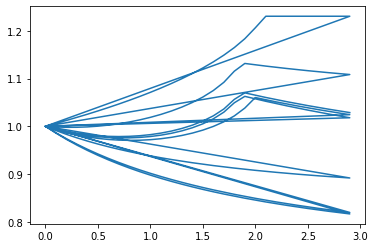

In [14]:
import matplotlib.pyplot as plt
plt.plot(Outcomes['varphi'], Outcomes['pe'])

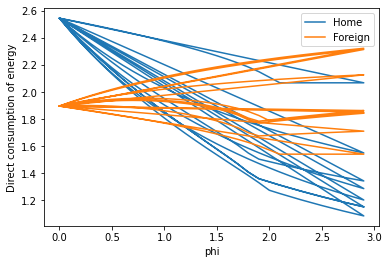

In [15]:
plt.plot(Outcomes['varphi'], Outcomes['Cec_prime'], label = "Home")
plt.plot(Outcomes['varphi'], Outcomes['Cecstar_prime'], label = "Foreign")
plt.xlabel("phi")
plt.ylabel("Direct consumption of energy")
plt.legend()
#plt.savefig('phi_cec.pdf', format='PDF')

In [16]:
Outcomes['petb'] = Outcomes['pe'] + Outcomes['tb']

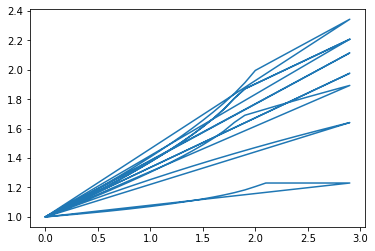

In [17]:
plt.plot(Outcomes['varphi'], Outcomes['petb'])

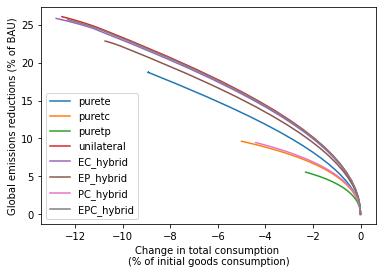

In [18]:
df = pd.read_csv('../../output_sig0/ces0.csv')
df = df[(df['region_scenario'] == 3) & (df['tax_sce'] == 'PC_hybrid') & (df['varphi'] <= 3)]
Outcomes['Qeworld_chg']=-(Outcomes['Qeworld_prime']-32.2760)/32.2760*100

df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'purete')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretc']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretc')

df_plot = Outcomes[Outcomes['tax_sce'] == 'puretp']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'puretp')

df_plot = Outcomes[Outcomes['tax_sce'] == 'Unilateral']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'unilateral')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EC_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EP_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EP_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'PC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'PC_hybrid')

df_plot = Outcomes[Outcomes['tax_sce'] == 'EPC_hybrid']  
plt.plot(df_plot['welfare_noexternality'], df_plot['Qeworld_chg'], label = 'EPC_hybrid')

#df['Qeworld_chg']=-(df['Qeworld_prime']-32.2760)/32.2760*100
#plt.plot(df['welfare_noexternality'], df['Qeworld_chg'], label = 'no direct consumption')

plt.xlabel('Change in total consumption \n(% of initial goods consumption)')
plt.ylabel('Global emissions reductions (% of BAU)')
plt.legend()

#plt.savefig('wf_chg.pdf', format = 'PDF')

C:\Users\Alex\AppData\Local\Temp/ipykernel_13428/958572098.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['Ceworld_prime'] = df_plot['Cec_prime'] + df_plot['Cecstar_prime'] + df_plot['Cey_prime'] + df_plot['Cem_prime'] + df_plot['Cex_prime'] + df_plot['Ceystar_prime']


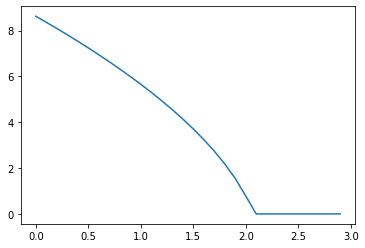

In [19]:
df_plot = Outcomes[Outcomes['tax_sce'] == 'purete']  
#plt.plot(df_plot['varphi'], df_plot['Qeworld_prime'], label = 'purete')
df_plot['Ceworld_prime'] = df_plot['Cec_prime'] + df_plot['Cecstar_prime'] + df_plot['Cey_prime'] + df_plot['Cem_prime'] + df_plot['Cex_prime'] + df_plot['Ceystar_prime']
plt.plot(df_plot['varphi'], df_plot['Qe_prime'], label = 'purete')

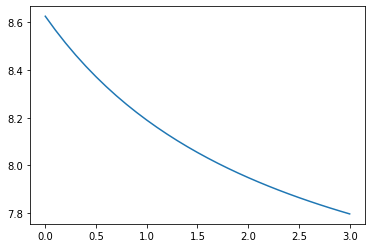

In [20]:
plt.plot(df['varphi'], df['Qe_prime'], label = 'purete')

In [21]:
df[['pe','tb', 'varphi','Cey_prime','Cex_prime','Vg_prime', 'Vgstar_prime', 'Vgx_prime', 'Vgm_prime']]

,pe,tb,varphi,Cey_prime,Cex_prime,Vg_prime,Vgstar_prime,Vgx_prime,Vgm_prime
3800,1.000000,0.000000,0.0,11.293670,0.910570,91.874733,123.298533,6.070467,16.5836
3801,0.986510,0.046870,0.1,10.928872,0.881510,91.874733,123.298533,5.969814,16.5836
3802,0.974072,0.092767,0.2,10.586111,0.854840,91.874733,123.298533,5.876343,16.5836
3803,0.962574,0.137787,0.3,10.263600,0.830295,91.874733,123.298533,5.789350,16.5836
3804,0.951920,0.182015,0.4,9.959712,0.807646,91.874733,123.298533,5.708214,16.5836
3805,0.942024,0.225526,0.5,9.672967,0.786693,91.874733,123.298533,5.632383,16.5836
3806,0.932810,0.268386,0.6,9.402023,0.767261,91.874733,123.298533,5.561372,16.5836
3807,0.924213,0.310653,0.7,9.145662,0.749198,91.874733,123.298533,5.494746,16.5836
3808,0.916176,0.352380,0.8,8.902777,0.732369,91.874733,123.298533,5.432121,16.5836
3809,0.908646,0.393613,0.9,8.672368,0.716658,91.874733,123.298533,5.373155,16.5836
